## Exploratory Data Analysis (EDA) of ThermoBase (v1.0 2022)

In [1]:
import os

import numpy as np
import pandas as pd

from scipy.interpolate import griddata

import plotly.express as px
import plotly.graph_objects as go

# For working with Jupyter lab
import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
DATA_DIR = "../data/"

#### Data preprocessing

In [3]:
data_df = pd.read_csv(
    os.path.join(DATA_DIR, "ThermoBase_ver_1.0_2022.csv"),
    sep=","
)

# Remove empty columns
data_df = data_df.filter(regex="^(?!Unnamed)")

# Remove spaces in columns
data_df.columns = [col.strip() for col in data_df.columns]

numerical_cols = [
    "Min. pH",
    "Max. pH",
    "Avg. Opt. pH",
    "Min. Temp. (°C)",
    "Max. Temp. (°C)",
    "Avg. Optimum Temp (°C)",
    "Pressure for Opt. Temp. (kpa)",
    "Optimum Pressure (Mpa)",
    "Avg. Opt. salinity (%)"
]

# Automatically extract numeric columns that need formatting (i.e. are object)
format_cols = set(numerical_cols).intersection(
    set(data_df.dtypes[data_df.dtypes == "object"].index)
)

# Convert to numeric avoiding ranges of variables and descriptions
# For data points in which there is a range, only the maximum is considered
for col in format_cols:
    # Get the rightmost element, assumed to be the maximum of the range
    data_df[col] = data_df[col].str.split("-").str[-1]

    # Remove spaces within numbers
    data_df[col] = data_df[col].str.replace(r"\s*", "", regex=True)

    # Force conversion to numeric, replacing strings with NaN
    data_df[col] = pd.to_numeric(data_df[col], errors="coerce")

data_df

,Name,Taxonomic ID,Domain,Phylum,Class,Order,Family,Ecosystem,Environment,Energy Source,...,Avg. Opt. pH,Min. Temp. (°C),Max. Temp. (°C),Avg. Optimum Temp (°C),Pressure for Opt. Temp. (kpa),Optimum Pressure (Mpa),Avg. Opt. salinity (%),Note,Source,Additional_source
0,Methanopyrus kandleri 116,2320,Archaea,Euryarchaeota,Methanomicrobia,Methanosarcinales,Methanosarcinaceae,Aquatic,Hydrothermal vent,Organotroph,...,6.45,90.0,122.0,105.0,40000.0,40.0,0.0300,NaN,https://www.pnas.org/content/105/31/10949,NaN
1,Geogemma barossii 121,1927912,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Pyrodictiaceae,Aquatic,Hydrothermal vent,Chemoautotroph,...,NaN,85.0,121.0,106.0,200.0,NaN,NaN,NaN,https://pubmed.ncbi.nlm.nih.gov/12920290/,NaN
2,"Pyrolobus fumarii 1A, DSM 11204",2505679005,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Pyrodictiaceae,Aquatic,Hydrothermal vent,Chemolithoautotroph,...,5.50,90.0,113.0,106.0,200.0,25.0,0.0170,NaN,https://pubmed.ncbi.nlm.nih.gov/9680332/,NaN
3,Pyrococcus kukulkanii NCB100,2687453501,Archaea,Euryarchaeota,Thermococci,Thermococcales,Thermococcaceae,Aquatic,Hydrothermal vent,Chemoorganoheterotroph,...,7.00,70.0,112.0,105.0,150.0,50.0,0.0275,NaN,https://www.microbiologyresearch.org/content/j...,NaN
4,Pyrodictium brockii S1,35616,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Pyrodictiaceae,Aquatic,Solfataric waters,Chemolithoautotroph,...,5.50,80.0,110.0,105.0,300.0,NaN,0.0150,NaN,https://www.microbiologyresearch.org/content/j...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,Geotoga aestuarianus,195750,Bacteria,Thermotogae,Thermotogae,Petrotogales,Petrotogacceae,Aquatic,Sinkhole,Heterotroph,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.sciencedirect.com/science/article/...,NaN
1234,Streptomyces bingchenggensis BCW-1,646862346,Bacteria,Actinobacteria,Actinomycetia,Streptomycetales,Streptomycetaceae,Terrestrial,Soil sediment,Chemoorganotroph,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://pubmed.ncbi.nlm.nih.gov/24299107/,NaN
1235,Thermus caldophilus,272,Bacteria,Deinococcus-Thermus,Deinococci,Thermales,Thermaceae,Aquatic,Hot spring,Heterotroph,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://academic.oup.com/jb/article-abstract/9...,NaN
1236,Thermus nonproteolyticus,116039,Bacteria,Deinococcus-Thermus,Deinococci,Thermales,Thermaceae,Aquatic,Hot spring,Heterotroph,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,NaN


In [4]:
data_df.columns.tolist()

['Name',
 'Taxonomic ID',
 'Domain',
 'Phylum',
 'Class',
 'Order',
 'Family',
 'Ecosystem',
 'Environment',
 'Energy Source',
 'Metabolism',
 'Extended Metabolism',
 'Ion for Chemiosmosis',
 'Oxygen Requirement',
 'Min. pH',
 'Max. pH',
 'Avg. Opt. pH',
 'Min. Temp. (°C)',
 'Max. Temp. (°C)',
 'Avg. Optimum Temp (°C)',
 'Pressure for Opt. Temp. (kpa)',
 'Optimum Pressure (Mpa)',
 'Avg. Opt. salinity (%)',
 'Note',
 'Source',
 'Additional_source']

#### Descriptive statistics

In [5]:
numerical_cols = data_df.select_dtypes(include=np.number).columns.tolist()

var_df = data_df[numerical_cols].copy()

var_df.describe()

,Min. pH,Max. pH,Avg. Opt. pH,Min. Temp. (°C),Max. Temp. (°C),Avg. Optimum Temp (°C),Pressure for Opt. Temp. (kpa),Optimum Pressure (Mpa),Avg. Opt. salinity (%)
count,498.000000,496.000000,524.000000,1145.000000,1175.000000,1206.000000,390.000000,34.000000,344.000000
mean,4.911325,7.775343,6.348092,38.411790,66.160255,58.056136,553.529231,33.897059,0.044760
std,1.662624,1.620822,2.241128,15.740523,15.330682,15.047719,6391.522162,33.628942,0.068364
min,0.000000,1.500000,0.700000,4.000000,40.000000,40.000000,50.000000,0.500000,0.000000
25%,4.500000,7.000000,6.000000,25.000000,55.000000,45.000000,101.000000,20.000000,0.005000
50%,5.500000,8.000000,6.800000,37.000000,65.000000,55.000000,101.000000,27.500000,0.020000
75%,6.000000,9.000000,7.250000,50.000000,75.000000,67.500000,200.000000,40.000000,0.030000
max,8.500000,11.200000,40.000000,90.000000,122.000000,106.000000,120000.000000,200.000000,0.270000


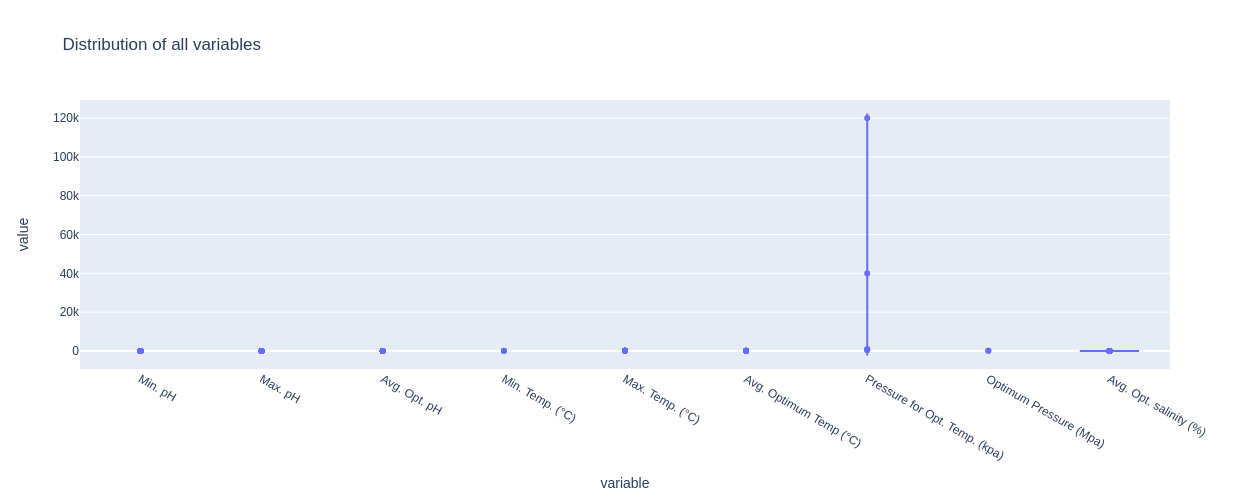

In [6]:
px.violin(
    data_frame=var_df,
    y=numerical_cols,
    title="Distribution of all variables",
    height=500,
    width=1250
).show("png")

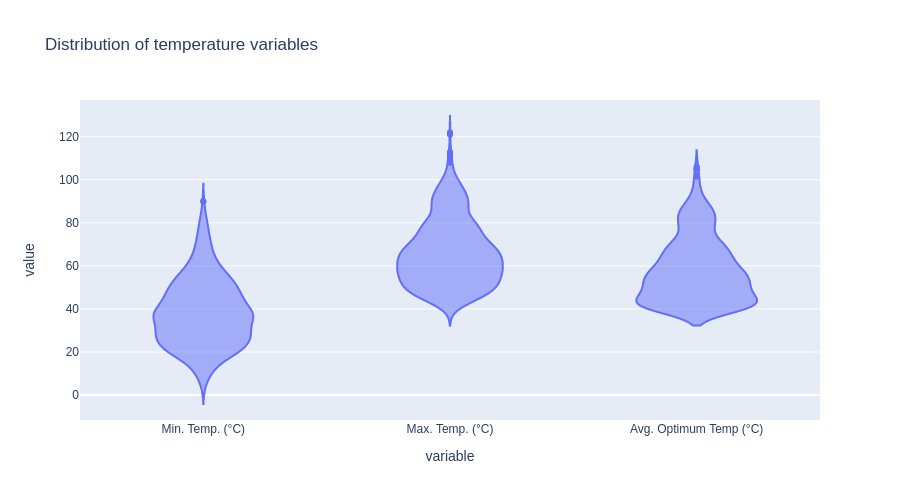

In [7]:
px.violin(
    data_frame=var_df,
    y=[
        "Min. Temp. (°C)",
        "Max. Temp. (°C)",
        "Avg. Optimum Temp (°C)"
    ],
    title="Distribution of temperature variables",
    height=500,
    width=900
).show("png")

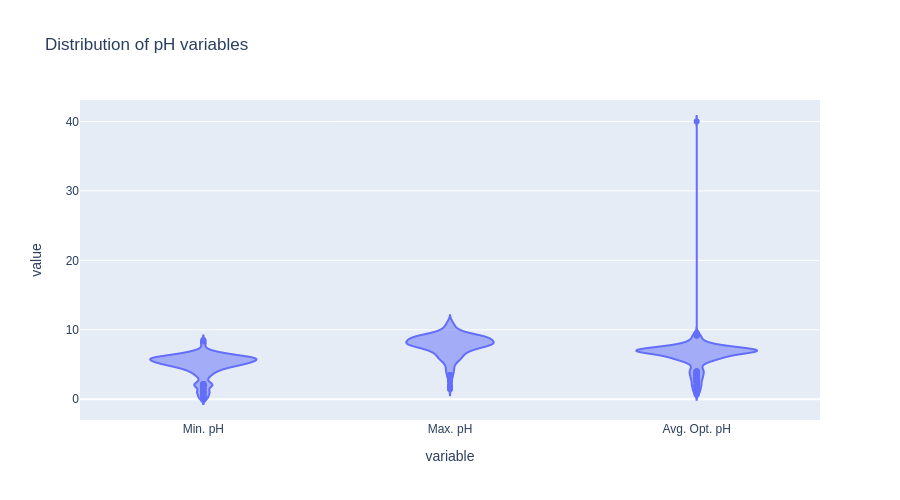

In [8]:
px.violin(
    data_frame=var_df,
    y=[
        "Min. pH",
        "Max. pH",
        "Avg. Opt. pH"
    ],
    title="Distribution of pH variables",
    height=500,
    width=900
).show("png")

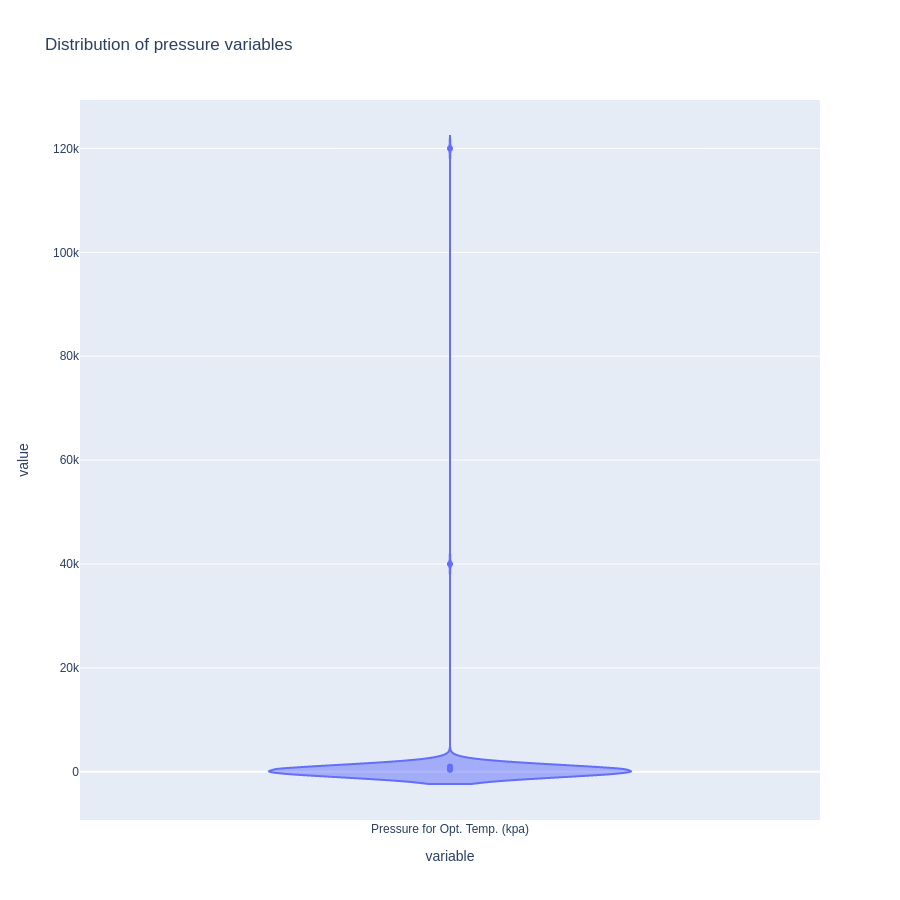

In [9]:
px.violin(
    data_frame=var_df,
    y=[
        "Pressure for Opt. Temp. (kpa)"
    ],
    title="Distribution of pressure variables",
    height=900,
    width=900
).show("png")

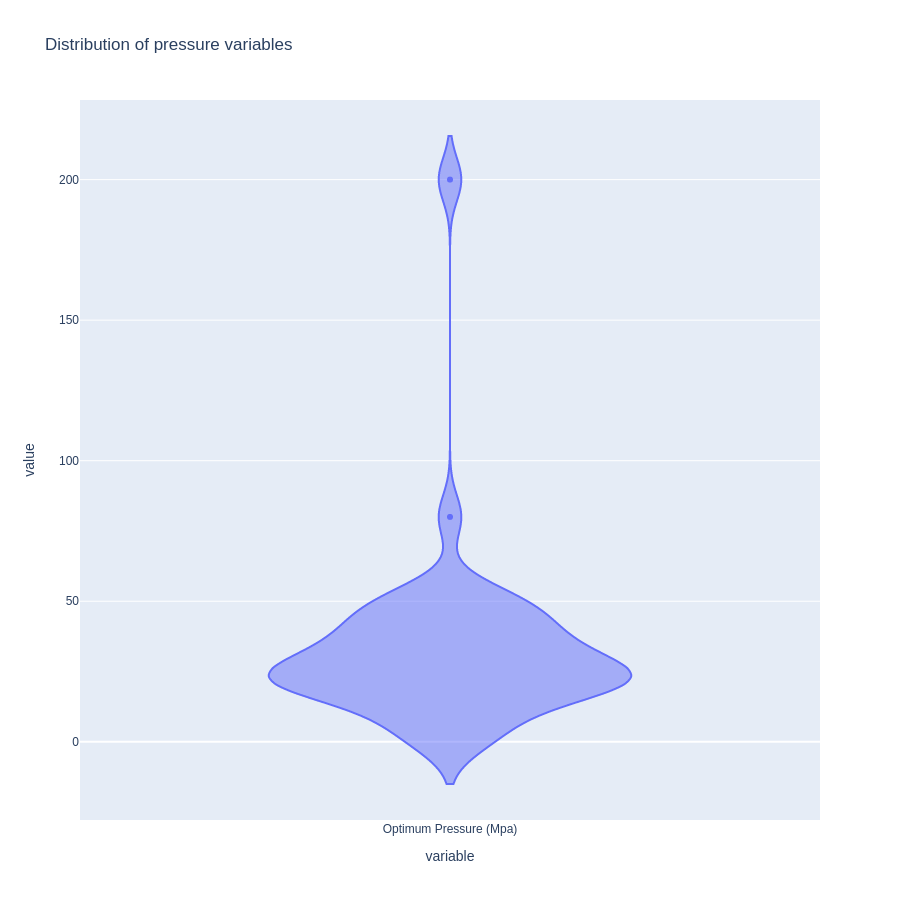

In [10]:
px.violin(
    data_frame=var_df,
    y=[
        "Optimum Pressure (Mpa)"
    ],
    title="Distribution of pressure variables",
    height=900,
    width=900
).show("png")

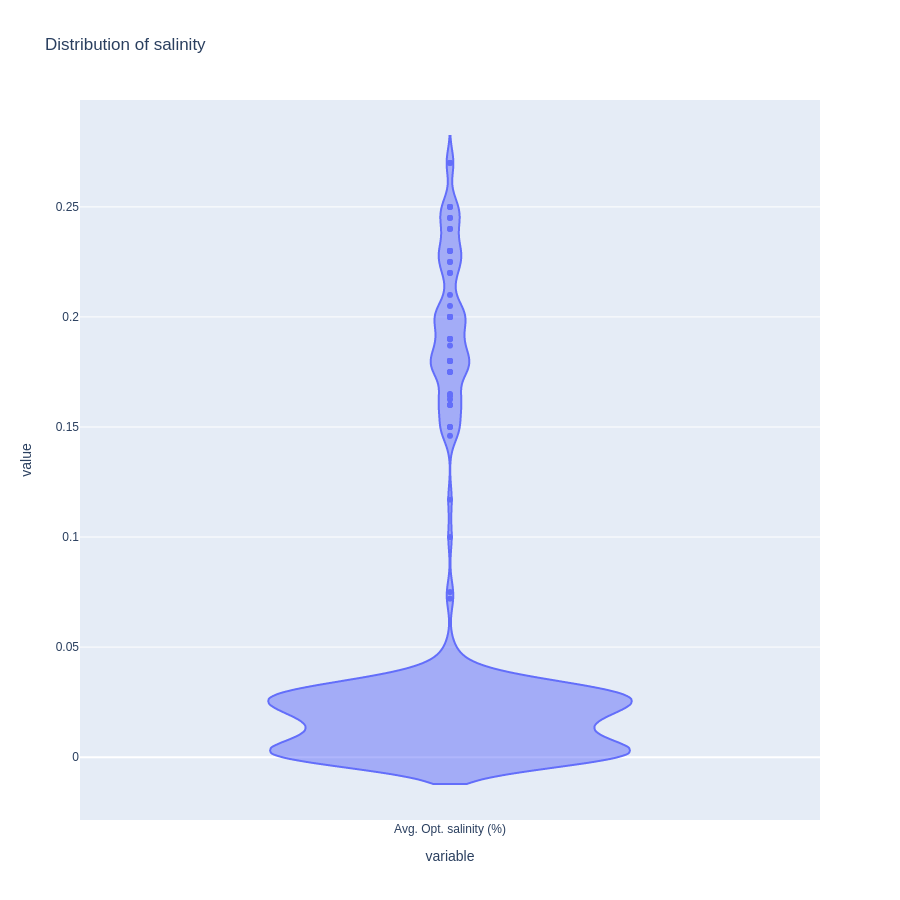

In [11]:
px.violin(
    data_frame=var_df,
    y=[
        "Avg. Opt. salinity (%)"
    ],
    title="Distribution of salinity",
    height=900,
    width=900
).show("png")

##### 3D visualizations

In [12]:
x_var = "Avg. Opt. pH"
y_var = "Avg. Optimum Temp (°C)"
z_var = "Optimum Pressure (Mpa)"

# x_var = "Min. Temp. (°C)"
# y_var = "Max. Temp. (°C)"
# z_var = "Avg. Optimum Temp (°C)"

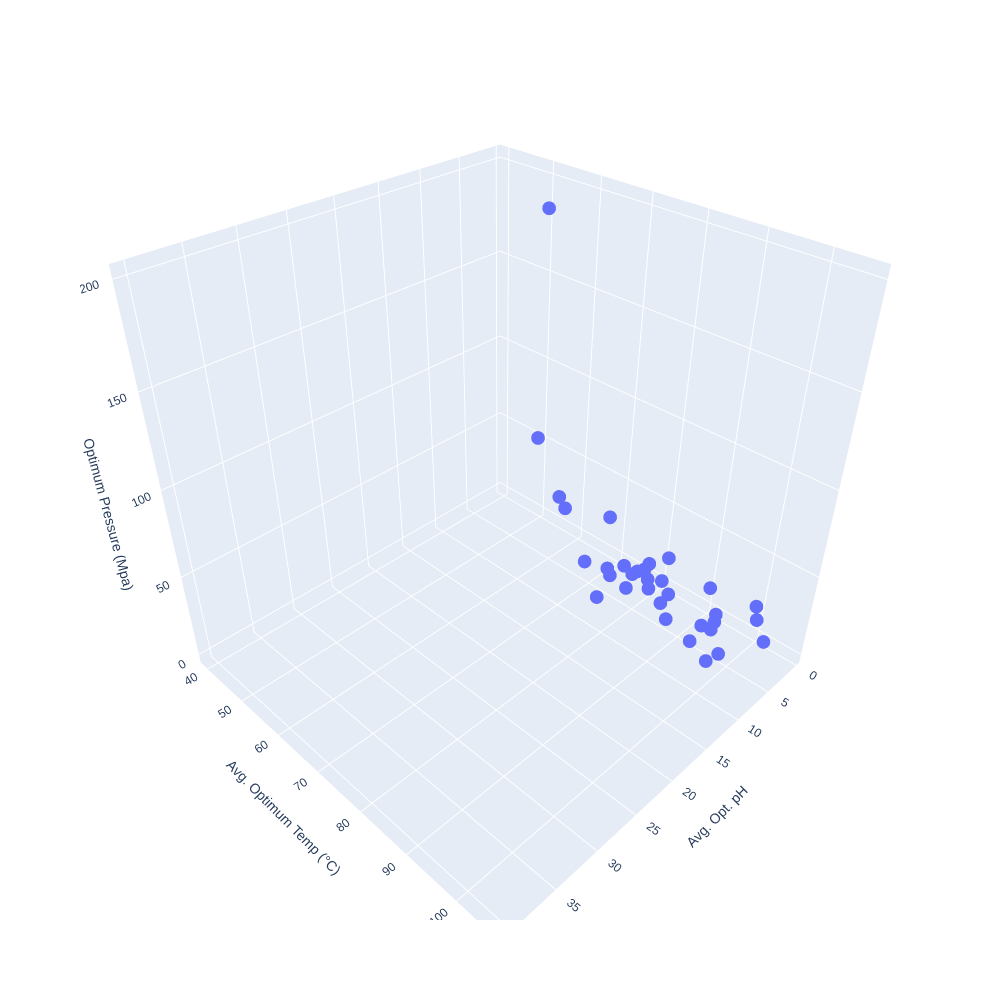

In [13]:
fig = px.scatter_3d(
    data_frame=data_df,
    x=x_var,
    y=y_var,
    z=z_var
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000
)
fig.show("png")

In [14]:
# Get values for X and Y axis (drop NaN, sort, convert to string)
x_var_values = data_df[x_var].dropna().sort_values().astype(str).unique()
y_var_values = data_df[y_var].dropna().sort_values().astype(str).unique()

# Create placeholder surface matrix
surface_df = pd.DataFrame(
    index=x_var_values,
    columns=y_var_values
)

# Populate surface matrix
for _, row in data_df.iterrows():
    surface_df.loc[
        str(row[x_var]),
        str(row[y_var])
    ] = row[z_var]

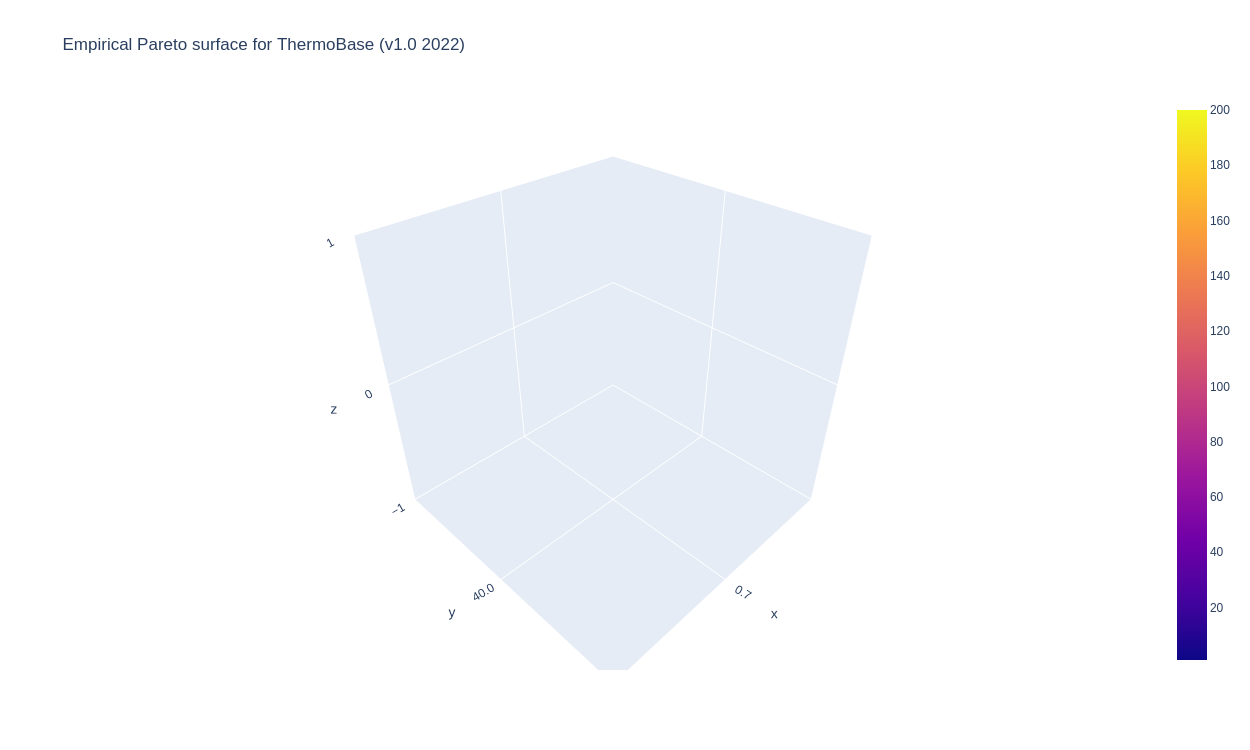

In [15]:
fig = go.Figure(
    data=[
        go.Surface(
            # contours = {
            #     # "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
            #     "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
            # },
            x=surface_df.index,
            y=surface_df.columns,
            z=surface_df.values
        )
    ]
)
fig.update_layout(
    title="Empirical Pareto surface for ThermoBase (v1.0 2022)",
    autosize=False,
    height=750,
    width=1250,
    # margin=dict(l=65, r=50, b=65, t=90)
)
fig.show("png")

The density of data is not enough for creating a surface, but we can interpolate between data points to try predict such surface.

In [16]:
# Linearly interpolate surface data
x, y = np.indices(surface_df.shape)
a = surface_df.values.astype(float)
surface_df_interp = a

surface_df_interp[np.isnan(surface_df_interp)] = griddata(
    points=(x[~np.isnan(a)], y[~np.isnan(a)]), # points we know
    values=a[~np.isnan(a)],                    # values we know
    xi=(x[np.isnan(a)], y[np.isnan(a)]),       # points to interpolate
    method="linear"
)

surface_df_interp = pd.DataFrame(
    surface_df_interp,
    index=surface_df.index,
    columns=surface_df.columns
)

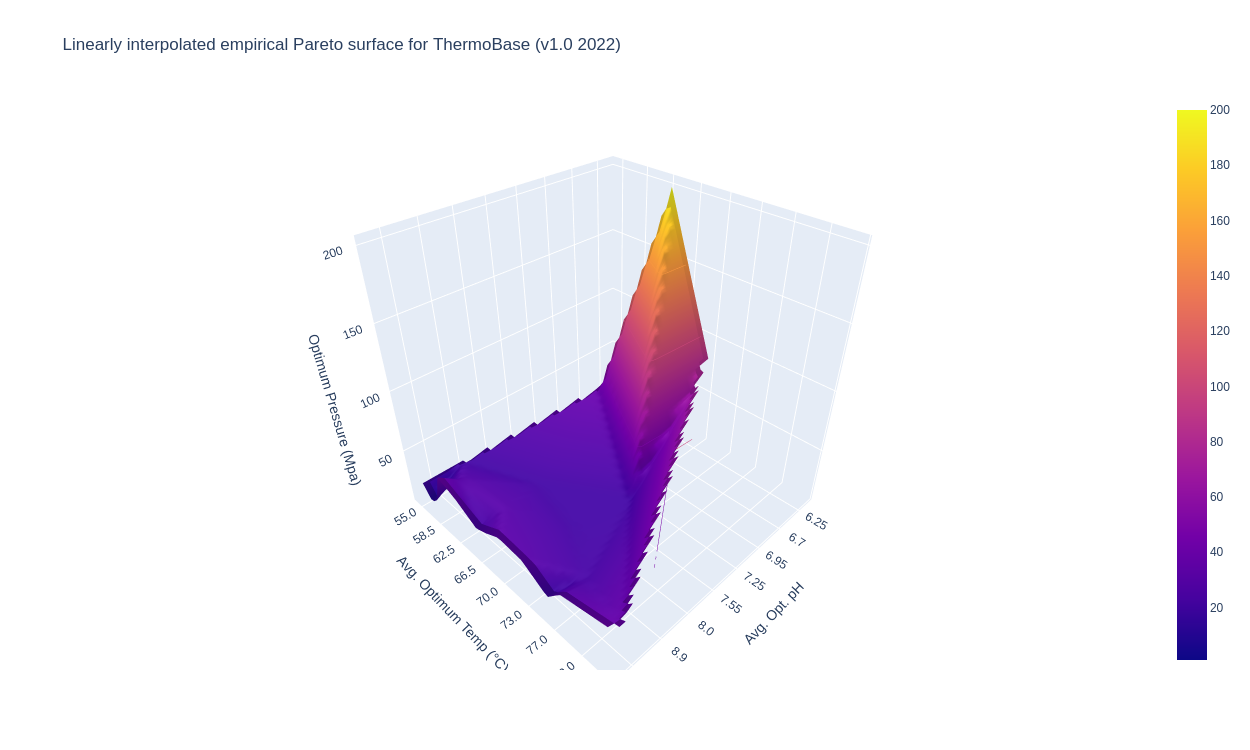

In [17]:
fig = go.Figure(
    data=[
        go.Surface(
            x=surface_df_interp.index,
            y=surface_df_interp.columns,
            z=surface_df_interp.values
        )
    ]
)
fig.update_traces(
    contours_z=dict(
        show=True,
        usecolormap=True,
        highlightcolor="limegreen",
        project_z=True
    )
)
fig.update_layout(
    title="Linearly interpolated empirical Pareto surface for ThermoBase (v1.0 2022)",
    autosize=False,
    height=750,
    width=1250,
    # margin=dict(l=65, r=50, b=65, t=90)
    scene=dict(
        xaxis_title=x_var,
        yaxis_title=y_var,
        zaxis_title=z_var
    )
)
fig.show("png")

A more beautiful visualization can be achieved by focusing on temperature variables only.

In [18]:
x_var = "Min. Temp. (°C)"
y_var = "Max. Temp. (°C)"
z_var = "Avg. Optimum Temp (°C)"

In [19]:
# Get values for X and Y axis (drop NaN, sort, convert to string)
x_var_values = data_df[x_var].dropna().sort_values().astype(str).unique()
y_var_values = data_df[y_var].dropna().sort_values().astype(str).unique()

# Create placeholder surface matrix
surface_df = pd.DataFrame(
    index=x_var_values,
    columns=y_var_values
)

# Populate surface matrix
for _, row in data_df.iterrows():
    surface_df.loc[
        str(row[x_var]),
        str(row[y_var])
    ] = row[z_var]

In [20]:
# Linearly interpolate surface data
x, y = np.indices(surface_df.shape)
a = surface_df.values.astype(float)
surface_df_interp = a

surface_df_interp[np.isnan(surface_df_interp)] = griddata(
    points=(x[~np.isnan(a)], y[~np.isnan(a)]), # points we know
    values=a[~np.isnan(a)],                    # values we know
    xi=(x[np.isnan(a)], y[np.isnan(a)]),       # points to interpolate
    method="linear"
)

surface_df_interp = pd.DataFrame(
    surface_df_interp,
    index=surface_df.index,
    columns=surface_df.columns
)

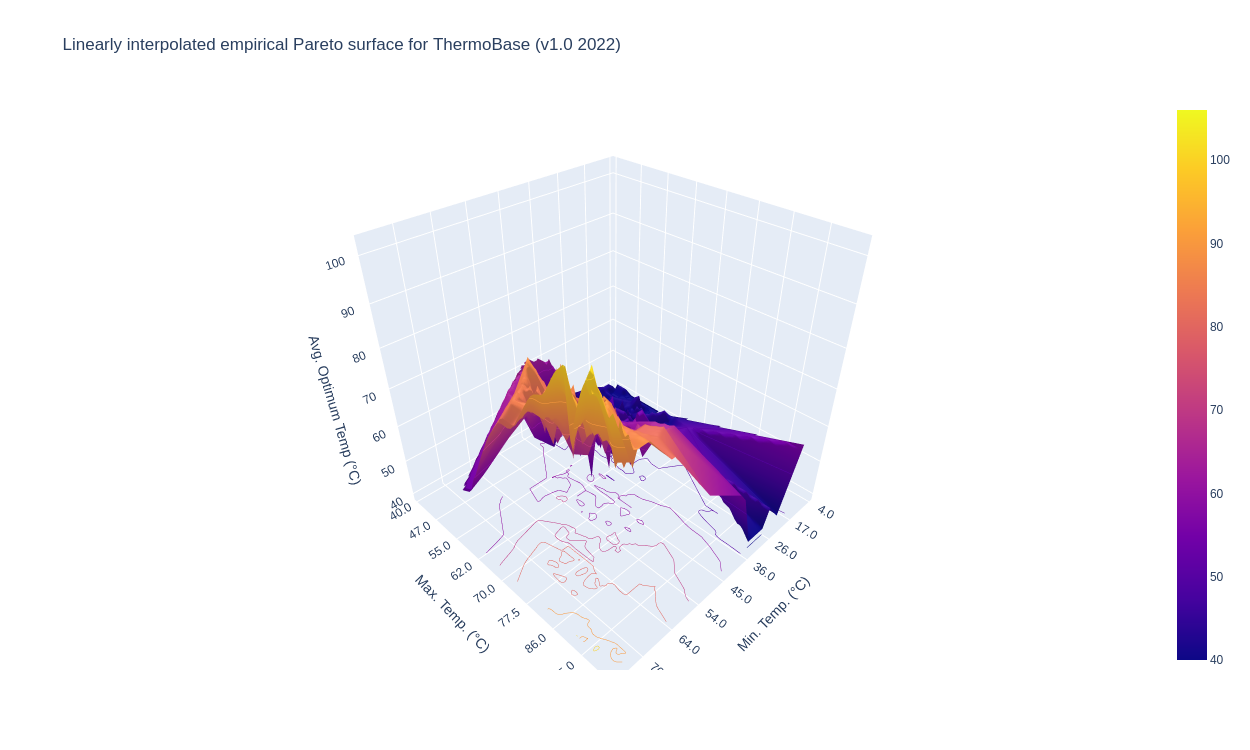

In [21]:
fig = go.Figure(
    data=[
        go.Surface(
            x=surface_df_interp.index,
            y=surface_df_interp.columns,
            z=surface_df_interp.values
        )
    ]
)
fig.update_traces(
    contours_z=dict(
        show=True,
        usecolormap=True,
        highlightcolor="limegreen",
        project_z=True
    )
)
fig.update_layout(
    title="Linearly interpolated empirical Pareto surface for ThermoBase (v1.0 2022)",
    autosize=False,
    height=750,
    width=1250,
    # margin=dict(l=65, r=50, b=65, t=90)
    scene=dict(
        xaxis_title=x_var,
        yaxis_title=y_var,
        zaxis_title=z_var,
        camera_eye=dict(
            x=-1,
            y=-2,
            z=0.5
        )
    )
)
fig.show("png")